# Introduction

Họ tên: Nguyễn Nam Dương\
MSV: 22022512\
Project này sẽ thực hiện classification cho các cặp ảnh doppelgangers.\
Method used: Notebook này sẽ thực hiện sử dụng depth_estimation để classify xem 2 ảnh có phản ánh cùng một bề mặt của cấu trúc 3D hay không.\
Future works: matching cho các cặp này thay vì dừng lại ở classification do giới hạn thời gian.\
\
Bài toán Doppelgangers là một vấn đề còn hiện hữu của Structure from Motion (SfM). Việc cải thiện và xử lý được bài toán này sẽ giúp cải thiện ứng dụng 3D Reconstruction rất nhiều do các công nghệ 3D Reconstruction hiện tại sẽ không thực hiện được nếu có lỗi trong khâu dữ liệu SfM.\
Giải pháp gần nhất cho vấn đề này [Doppelgangers++: Improved Visual Disambiguation with Geometric 3D Features](https://arxiv.org/html/2412.05826v1) được publish gần đây vào 8/12/2024 cũng đã propose việc sử dụng cấu trúc MASt3R Backbone cho tác vụ này (tương tự dinov2 backbone nhưng được finetuned riêng cho tác vụ matching và yêu cầu phần cứng, chi phí tính toán và sử dụng lớn hơn nhiều).\
\
Project này nhằm thử nghiệm phương pháp sử dụng [facebookresearch/dinov2](https://github.com/facebookresearch/dinov2/tree/main) backbone (nhẹ hơn và là mô hình visual features backbone tổng thể không được chuyên dụng hóa cho tác vụ nhất định). Kỳ vọng sẽ có thể hướng tới giải pháp chi phí thấp và tốc độ tốt hơn.

# Đối tượng dữ liệu thử nghiệm

Vì tập data là vô cùng lớn, ở project này chỉ sử dụng các cặp ảnh từ Khải Hoàn Môn (Arc_de_triomphe) trong tập dữ liệu không có flip ảnh.\
Phần mấu chốt ở đây là kiểm chứng method có độ hiệu quả ra sao.\
\
Thử nghiệm ở phần "classification_window_direct_trial" là những thử nghiệm ban đầu và thực hiện trên Windows và chưa được sắp xếp cũng như tổ chức code lại. Thử nghiệm được thực hiện trên dữ liệu cặp ảnh được tạo bằng cách duyệt dfs và sắp xếp lại đường dẫn file (xem trong "classification_window_direct_trial\doppelgangers_data") do cấu trúc file cùng với các file được đặt tên theo cấu trúc chỉ sử dụng được trên Linux.\
\
Việc chỉ sử dụng out feature của dinov2 backbone đã được kiểm chứng là không đủ khả năng thực hiện task này. Chỉ bằng việc chọn một vài cặp ảnh để kiểm chứng, ta có thể thấy được mô hình không có khả năng nhận phân biệt được 2 ảnh có phản ánh cùng một bề mặt cấu trúc 3D hay không.\
Có xem ở "classification_window_direct_trial/testing_finetuned.ipynb".


# Data

Đọc ảnh và tạo Dataloader

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import cv2

# Function to load images
def load_image(path):
    cv_type = cv2.IMREAD_COLOR
    image = None
    if str(path).endswith('gif'):
        pil_image = Image.open(str(path))
        if pil_image.mode == "P":
            pil_image = pil_image.convert("RGB")
        image = np.array(pil_image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        image = cv2.imread(str(path), cv_type)

    if image is None:
        print(f"image {path} is None")
        return None
    if len(image.shape) < 3:
        image = image[:, :, np.newaxis]
    if image.shape[2] < 3:
        image = np.concatenate((image, image, image), axis=2)
    return image  # (h, w, 3)

# Dataset Definition
class ImagePairsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1_path, img2_path, label = row["Image1"], row["Image2"], row["Label"]

        # Function to load images with retry mechanism
        def try_load_image(image_path, max_retries=5):
            for attempt in range(max_retries):
                try:
                    image = load_image(image_path)
                    if image is not None:
                        return image
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed to load image {image_path}: {e}")
            raise ValueError(f"Failed to load image {image_path} after {max_retries} attempts.")

        # Try loading both images
        img1 = try_load_image(img1_path)
        img2 = try_load_image(img2_path)

        # Convert to PIL Image for transformation
        img1 = Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        img2 = Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


# K-Fold Data Preparation
def prepare_data_kfold(npy_path, data_folder="train_set_noflip", k=5, batch_size=8):
    # Load the NumPy file
    data = np.load(npy_path, allow_pickle=True)
    
    # Convert the NumPy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Image1', 'Image2', 'Label', 'matches'])
    
    # Filter the DataFrame
    df = df[(df['Image1'].str.contains('Arc_de_Triomphe_du_Carrousel_by_angle')) | 
            (df['Image2'].str.contains('Arc_de_Triomphe_du_Carrousel_by_angle'))]

    # Drop the 'matches' column
    df = df.drop(columns=['matches'])

    # Remove pairs that contain "flip" in their names
    df = df[~df['Image1'].str.contains('flip') & ~df['Image2'].str.contains('flip')]

    # Add "dpg_data/doppelgangers/images/<data_folder>/" to the beginning of the image names
    df['Image1'] = 'dpg_data/doppelgangers/images/' + data_folder + '/' + df['Image1']
    df['Image2'] = 'dpg_data/doppelgangers/images/' + data_folder + '/' + df['Image2']

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    splits = list(kf.split(df))

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Prepare loaders for each fold
    loaders = []
    for i, (train_idx, test_idx) in enumerate(splits):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        train_dataset = ImagePairsDataset(train_df, transform=transform)
        test_dataset = ImagePairsDataset(test_df, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        loaders.append((train_loader, test_loader))

    return loaders

# Model

Model gồm có dinov2 backbone, depthther và classifier. Phần ResNet đã được lược bỏ do có tính trùng lặp với backbone và 1 phần lý do giới hạn phần cứng.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from dinov2.eval.depth.models import build_depther
from zmq import device
import mmcv
from mmcv.runner import load_checkpoint

import math
import itertools
import urllib

device = "cuda" if torch.cuda.is_available() else "cpu"

def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()

# CenterPadding class from depth_estimation.ipynb
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output

# Function to create depth estimator
def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

# Load DINOv2 Backbone
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
backbone.eval()

# Load depth estimator
HEAD_DATASET = "nyu"
HEAD_TYPE = "dpt"
DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/dinov2_vitb14/dinov2_vitb14_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/dinov2_vitb14/dinov2_vitb14_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

depth_model = create_depther(
    cfg,
    backbone_model=backbone,
    backbone_size="base",
    head_type=HEAD_TYPE,
)
load_checkpoint(depth_model, head_checkpoint_url, map_location="cpu")
depth_model.eval()
depth_model.cuda()

# Adjusted VisualDisambiguationModel
class VisualDisambiguationModel(nn.Module):
    def __init__(self, backbone, depth_model, resnet_out_channels=512):
        super().__init__()
        self.backbone = backbone
        self.depth_model = depth_model
        self.classifier = nn.Sequential(
            nn.Linear(768*2, 256),  # vitb14 has 768 features
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        

    def forward(self, img1, img2):
        # Get depth estimation
        depth1 = self.depth_model.whole_inference(img1, img_meta=None, rescale=True)
        depth2 = self.depth_model.whole_inference(img2, img_meta=None, rescale=True)
        
        # Apply depth as mask
        feat1 = self.backbone(img1 * depth1)
        feat2 = self.backbone(img2 * depth2)

        # Flatten the features and concatenate
        feat1 = feat1.view(feat1.size(0), -1)
        feat2 = feat2.view(feat2.size(0), -1)
        combined_features = torch.cat((feat1, feat2), dim=1)

        return self.classifier(combined_features)

/home/duonn512/miniconda3/envs/dino_env/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
Using cache found in /home/duonn512/.cache/torch/hub/facebookresearch_dinov2_main
/mnt/d/CodesNStuffs/DinoV2_Classification/augmented_dpp/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/mnt/d/CodesNStuffs/DinoV2_Classification/augmented_dpp/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/mnt/d/CodesNStuffs/DinoV2_Classification/augmented_dpp/dinov2/layers/block.py:33: UserWarning: xF

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_nyu_dpt_head.pth


# Train and eval function

Training and evaluating script

In [3]:
from tqdm import tqdm  # Import tqdm for progress bar
import torch.optim as optim
from PIL import UnidentifiedImageError  # Import the error to handle image loading failures

# Training Loop
def train_model(train_loader, model, optimizer, criterion, device):
    model.train()

    # Freeze the backbone (feature extractor) of the model
    for param in model.backbone.parameters():
        param.requires_grad = False

    for param in model.depth_model.parameters():
        param.requires_grad = False

    running_loss = 0.0
    failed_images = []  # List to store failed image pairs for logging

    with tqdm(train_loader, unit="batch") as tepoch:
        for img1, img2, labels in tepoch:
            try:
                # Skip batches with None (invalid image pairs)
                if img1 is None or img2 is None:
                    continue

                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(img1, img2).squeeze()  # Directly pass images to the model
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1))

            except UnidentifiedImageError as e:
                failed_images.append((img1, img2))  # Log the image pair that caused the issue
                tepoch.set_postfix(loss="Image Load Error")

            except Exception as e:
                failed_images.append((img1, img2))  # Log any other errors
                tepoch.set_postfix(loss="Unknown Error")
                print(f"Error in batch {tepoch.n}: {str(e)}")

    # Log all failed images after training
    if failed_images:
        print(f"\nFailed to load {len(failed_images)} image pairs during training.")
        for img1, img2 in failed_images:
            print(f"Failed image pair: {img1}, {img2}")

    return running_loss / len(train_loader)

# Evaluation Loop
def evaluate_model(test_loader, model, criterion, device):
    model.eval()

    # Freeze the backbone (feature extractor) of the model
    for param in model.backbone.parameters():
        param.requires_grad = False

    running_loss = 0.0
    correct = 0
    total = 0
    failed_images = []  # List to store failed image pairs for logging

    with tqdm(test_loader, unit="batch") as tepoch:
        with torch.no_grad():
            for img1, img2, labels in tepoch:
                try:
                    # Skip batches with None (invalid image pairs)
                    if img1 is None or img2 is None:
                        continue

                    img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                    outputs = model(img1, img2).squeeze()  # Directly pass images to the model
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    preds = (outputs > 0.5).float()
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=running_loss / (tepoch.n + 1))

                except UnidentifiedImageError as e:
                    failed_images.append((img1, img2))  # Log the image pair that caused the issue
                    tepoch.set_postfix(loss="Image Load Error")

                except Exception as e:
                    failed_images.append((img1, img2))  # Log any other errors
                    tepoch.set_postfix(loss="Unknown Error")
                    print(f"Error in batch {tepoch.n}: {str(e)}")

    # Log all failed images after evaluation
    if failed_images:
        print(f"\nFailed to load {len(failed_images)} image pairs during evaluation.")
        for img1, img2 in failed_images:
            print(f"Failed image pair: {img1}, {img2}")

    accuracy = correct / total
    return running_loss / len(test_loader), accuracy


# Train and test

Train với (k=3)-fold cross-validation, 5epoch mỗi fold.

In [4]:
import torch.hub
import torch.optim as optim
import torch.nn as nn

npy_pth = "dpg_data/doppelgangers/pairs_metadata/train_pairs_noflip.npy"
k = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data with K-Fold
loaders = prepare_data_kfold(npy_pth, k=k)

# Initialize the model with the new ResNet-integrated structure
model = VisualDisambiguationModel(
    backbone=backbone,
    depth_model=depth_model
).to(device)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

for fold, (train_loader, test_loader) in enumerate(loaders):
    print(f"Fold {fold + 1}/{k}")

    # Train
    for epoch in range(5):  # 5 epochs per fold
        train_loss = train_model(train_loader, model, optimizer, criterion, device)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Evaluate
    test_loss, accuracy = evaluate_model(test_loader, model, criterion, device)
    print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4%}")


Fold 1/3


100%|██████████| 152/152 [06:16<00:00,  2.47s/batch, loss=0.374]


Epoch 1, Train Loss: 0.3738


100%|██████████| 152/152 [06:15<00:00,  2.47s/batch, loss=0.183]


Epoch 2, Train Loss: 0.1825


100%|██████████| 152/152 [06:17<00:00,  2.48s/batch, loss=0.122]


Epoch 3, Train Loss: 0.1216


100%|██████████| 152/152 [06:26<00:00,  2.54s/batch, loss=0.0811]


Epoch 4, Train Loss: 0.0811


100%|██████████| 152/152 [06:17<00:00,  2.49s/batch, loss=0.0608]


Epoch 5, Train Loss: 0.0608


100%|██████████| 76/76 [03:23<00:00,  2.67s/batch, loss=0.0946]


Fold 1 - Test Loss: 0.0946, Accuracy: 97.5288%
Fold 2/3


100%|██████████| 152/152 [05:28<00:00,  2.16s/batch, loss=0.0654]


Epoch 1, Train Loss: 0.0654


100%|██████████| 152/152 [04:42<00:00,  1.86s/batch, loss=0.0378]


Epoch 2, Train Loss: 0.0378


100%|██████████| 152/152 [04:34<00:00,  1.81s/batch, loss=0.0239]


Epoch 3, Train Loss: 0.0239


100%|██████████| 152/152 [04:21<00:00,  1.72s/batch, loss=0.0188]


Epoch 4, Train Loss: 0.0188


100%|██████████| 152/152 [04:17<00:00,  1.69s/batch, loss=0.0156]


Epoch 5, Train Loss: 0.0156


100%|██████████| 76/76 [02:06<00:00,  1.67s/batch, loss=0.0305]


Fold 2 - Test Loss: 0.0305, Accuracy: 98.8468%
Fold 3/3


100%|██████████| 152/152 [04:20<00:00,  1.71s/batch, loss=0.0236]


Epoch 1, Train Loss: 0.0236


100%|██████████| 152/152 [04:27<00:00,  1.76s/batch, loss=0.0152]


Epoch 2, Train Loss: 0.0152


100%|██████████| 152/152 [05:26<00:00,  2.15s/batch, loss=0.00912]


Epoch 3, Train Loss: 0.0091


100%|██████████| 152/152 [05:24<00:00,  2.13s/batch, loss=0.00691]


Epoch 4, Train Loss: 0.0069


100%|██████████| 152/152 [05:22<00:00,  2.12s/batch, loss=0.00585]


Epoch 5, Train Loss: 0.0058


100%|██████████| 76/76 [02:39<00:00,  2.10s/batch, loss=0.00891]

Fold 3 - Test Loss: 0.0089, Accuracy: 100.0000%


# Save model

In [5]:
model_save_path = "visual_disambiguation_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to visual_disambiguation_model.pth


# Test với các cặp ảnh và visualize

Test với các cặp từ bộ test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0125492].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front/0/1/pictures/Arco del Triunfo - panoramio - anibal amaro.jpg
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front/0/2/pictures/Arc de Triomph France Paris.jpg


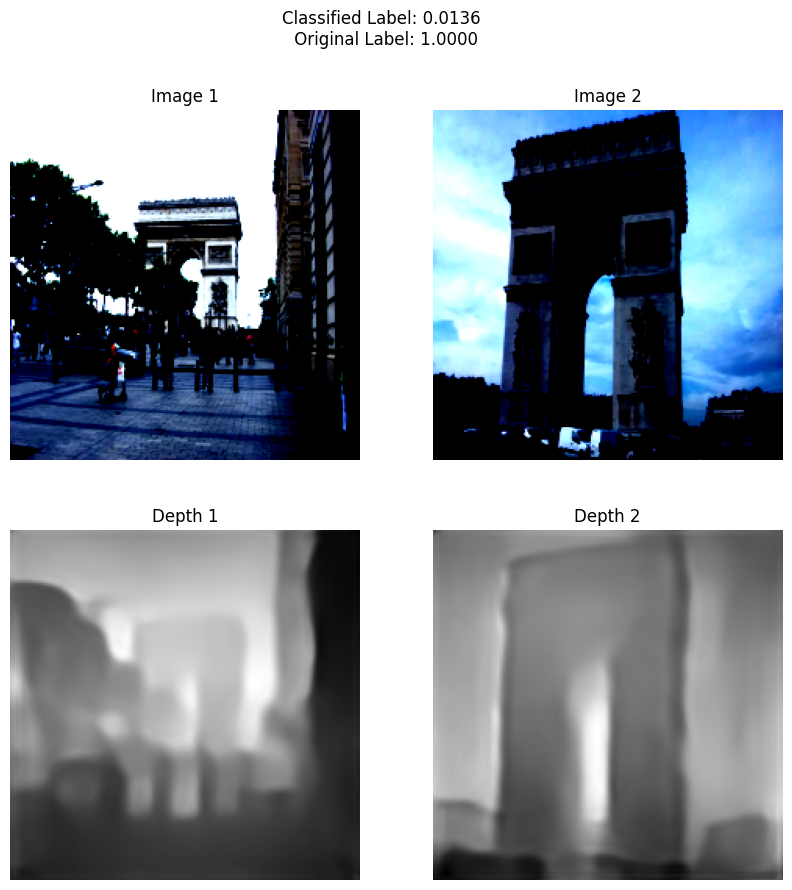

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as T
from PIL import Image
import torch
import cv2


# Load the saved model
model_save_path = "visual_disambiguation_model.pth"
model = VisualDisambiguationModel(backbone=backbone, depth_model=depth_model).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Function to display images
def display_images(img1, img2, img1_path, img2_path, depth1, depth2, label_original, label):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Display original images
    axes[0, 0].imshow(img1.permute(1, 2, 0).cpu().numpy())
    axes[0, 0].set_title("Image 1")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img2.permute(1, 2, 0).cpu().numpy())
    axes[0, 1].set_title("Image 2")
    axes[0, 1].axis('off')
    
    # Display depth outputs
    axes[1, 0].imshow(depth1.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 0].set_title("Depth 1")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(depth2.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 1].set_title("Depth 2")
    axes[1, 1].axis('off')
    
    print(f"Image 1: {img1_path}")
    print(f"Image 2: {img2_path}")
    plt.suptitle(f"Classified Label: {label.item():.4f} \n Original Label: {label_original.item():.4f}")
    plt.show()

# Function to load images
def load_image(path):
    cv_type = cv2.IMREAD_COLOR
    image = None
    if str(path).endswith('gif'):
        pil_image = Image.open(str(path))
        if pil_image.mode == "P":
            pil_image = pil_image.convert("RGB")
        image = np.array(pil_image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        image = cv2.imread(str(path), cv_type)

    if image is None:
        print(f"image {path} is None")
        return None
    if len(image.shape) < 3:
        image = image[:, :, np.newaxis]
    if image.shape[2] < 3:
        image = np.concatenate((image, image, image), axis=2)
    return image  # (h, w, 3)

# Load a random pair of images from the dataset
def get_random_image_pair(dataframe, transform):
    random_row = dataframe.sample(n=1).iloc[0]
    img1_path, img2_path, label = random_row["Image1"], random_row["Image2"], random_row["Label"]
    
    img1 = load_image(img1_path)
    img2 = load_image(img2_path)
    
    if img1 is None or img2 is None:
        raise ValueError("Failed to load one of the images.")
    
    img1 = Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    img2 = Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    
    if transform:
        img1 = transform(img1)
        img2 = transform(img2)
    
    return img1, img2, img1_path, img2_path, label

# Example usage
npy_pth = "dpg_data/doppelgangers/pairs_metadata/test_pairs.npy"
data_folder = "test_set"
data = np.load(npy_pth, allow_pickle=True)
df = pd.DataFrame(data, columns=['Image1', 'Image2', 'Label', 'matches'])
df = df[(df['Image1'].str.contains('Arc_de_Triomphe_de_l%27%C3%89toile_by_angle')) | 
        (df['Image2'].str.contains('Arc_de_Triomphe_de_l%27%C3%89toile_by_angle'))]
df = df.drop(columns=['matches'])
df = df[~df['Image1'].str.contains('flip') & ~df['Image2'].str.contains('flip')]
df['Image1'] = 'dpg_data/doppelgangers/images/' + data_folder + '/' + df['Image1']
df['Image2'] = 'dpg_data/doppelgangers/images/' + data_folder + '/' + df['Image2']

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img1, img2, img1_path, img2_path, label_original = get_random_image_pair(df, transform)

# Create image clone to render
img1_render = img1.clone().detach()
img2_render = img2.clone().detach()

# Move images to device
img1 = img1.unsqueeze(0).to(device)
img2 = img2.unsqueeze(0).to(device)

# Clone the tensors to avoid saving them for backward computation
img1_clone = img1.clone().detach()
img2_clone = img2.clone().detach()

# Get depth estimation
with torch.no_grad():
    depth1 = model.depth_model.whole_inference(img1_clone, img_meta=None, rescale=True)
    depth2 = model.depth_model.whole_inference(img2_clone, img_meta=None, rescale=True)

# Get classification label
with torch.no_grad():
    label = model(img1, img2).squeeze()

# Display images and results
display_images(img1_render, img2_render, img1_path, img2_path, depth1, depth2, label_original, label)

Tạo hàm để test

In [5]:
# Function to process and display a pair of images
from torch import seed


def process_and_display_pair(model, df, transform, device):
    img1, img2, img1_path, img2_path, label_original = get_random_image_pair(df, transform)

    # Create image clone to render
    img1_render = img1.clone().detach()
    img2_render = img2.clone().detach()

    # Move images to device
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    # Clone the tensors to avoid saving them for backward computation
    img1_clone = img1.clone().detach()
    img2_clone = img2.clone().detach()

    # Get depth estimation
    with torch.no_grad():
        depth1 = model.depth_model.whole_inference(img1_clone, img_meta=None, rescale=True)
        depth2 = model.depth_model.whole_inference(img2_clone, img_meta=None, rescale=True)

    # Get classification label
    with torch.no_grad():
        label = model(img1, img2).squeeze()

    # Display images and results
    display_images(img1_render, img2_render, img1_path, img2_path, depth1, depth2, label_original, label)
    
def test_n_pairs(n = 5, seed = 1):
    np.random.seed(seed)
    for i in range(n):
        process_and_display_pair(model, df, transform, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/back_left/0/1/pictures/Arc de triomphe (Paris) (1).jpg
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/back_left/0/3/pictures/COVID-19 Paris confinement, Place Charles de Gaulle, 4 avril 2020 001.jpg


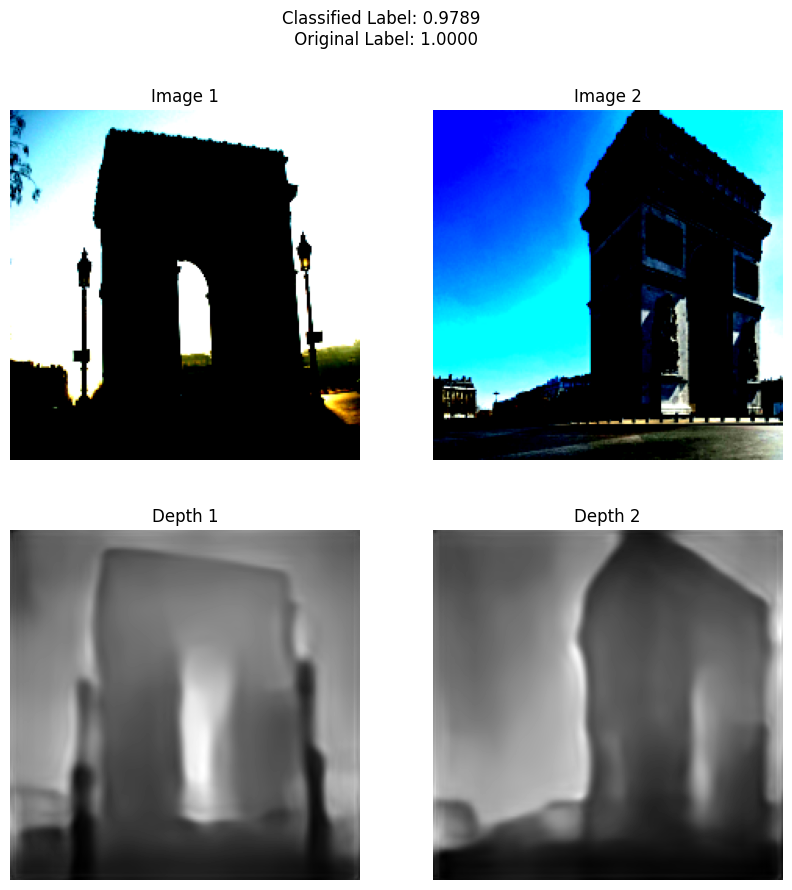

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.465708].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_left/0/1/pictures/Arc de Triomphe de l'Étoile - Feb 2008.jpg
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_left/0/1/pictures/Arc de triomphe evening 20070120.jpg


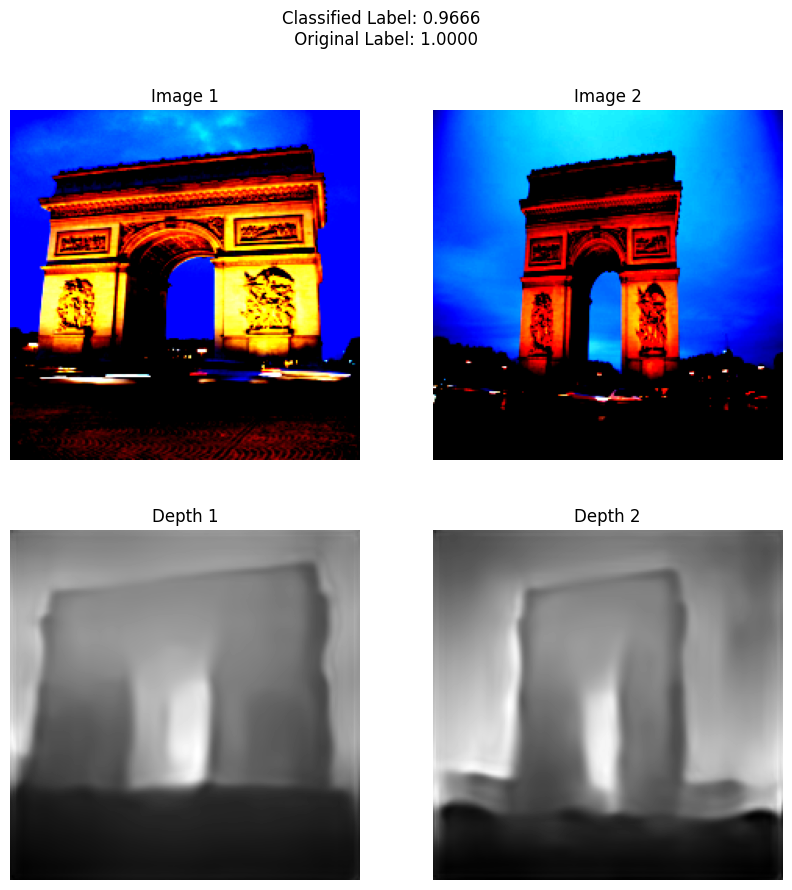

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..2.4831376].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/back_left/0/2/pictures/11 juillet 2017 Paris 4.jpg
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_right/0/2/pictures/Bruno (8653055794).jpg


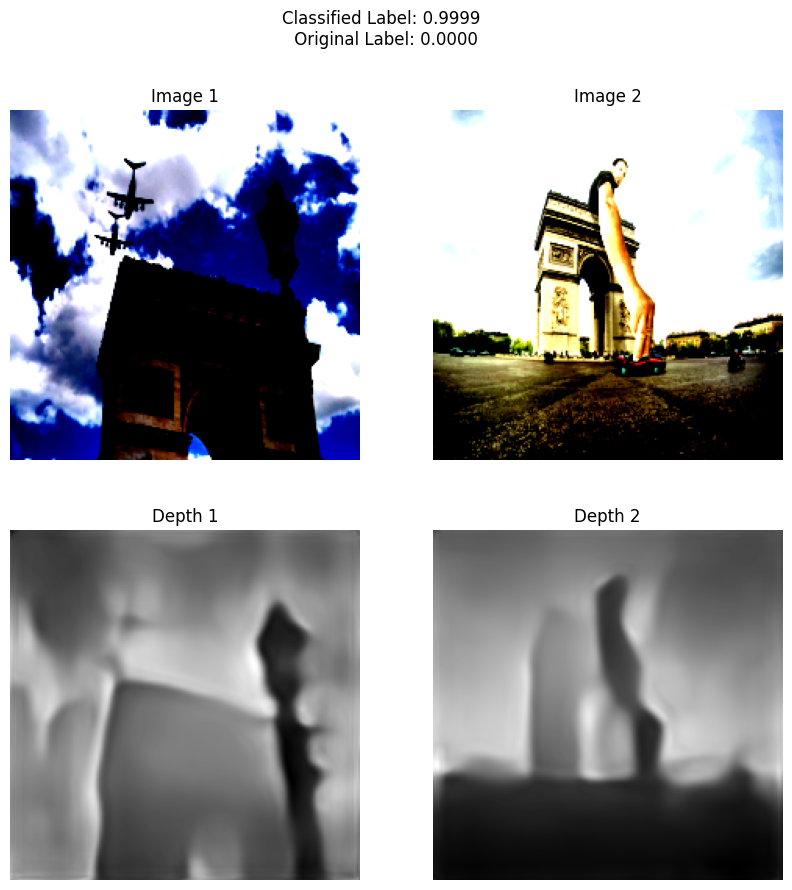

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.465708].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_left/0/1/pictures/Arc de Triomphe Night.JPG
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_left/0/1/pictures/Arc de triomphe evening 20070120.jpg


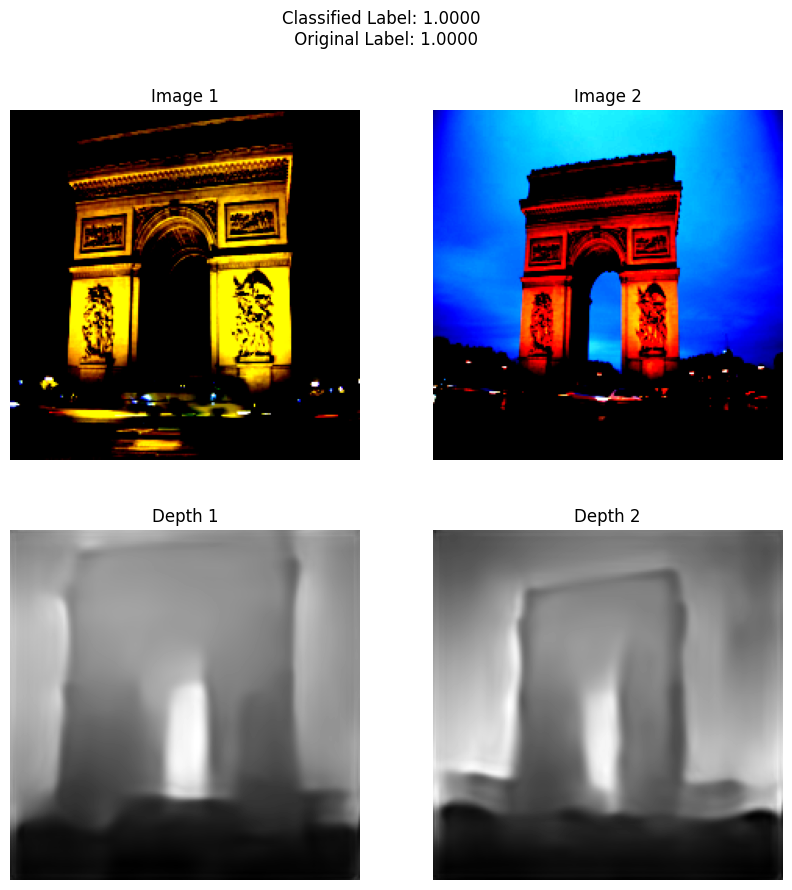

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].


Image 1: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/back_left/0/1/pictures/凱旋門 - panoramio.jpg
Image 2: dpg_data/doppelgangers/images/test_set/Arc_de_Triomphe_de_l%27%C3%89toile_by_angle/front_right/0/2/pictures/凯旋门 - panoramio (1).jpg


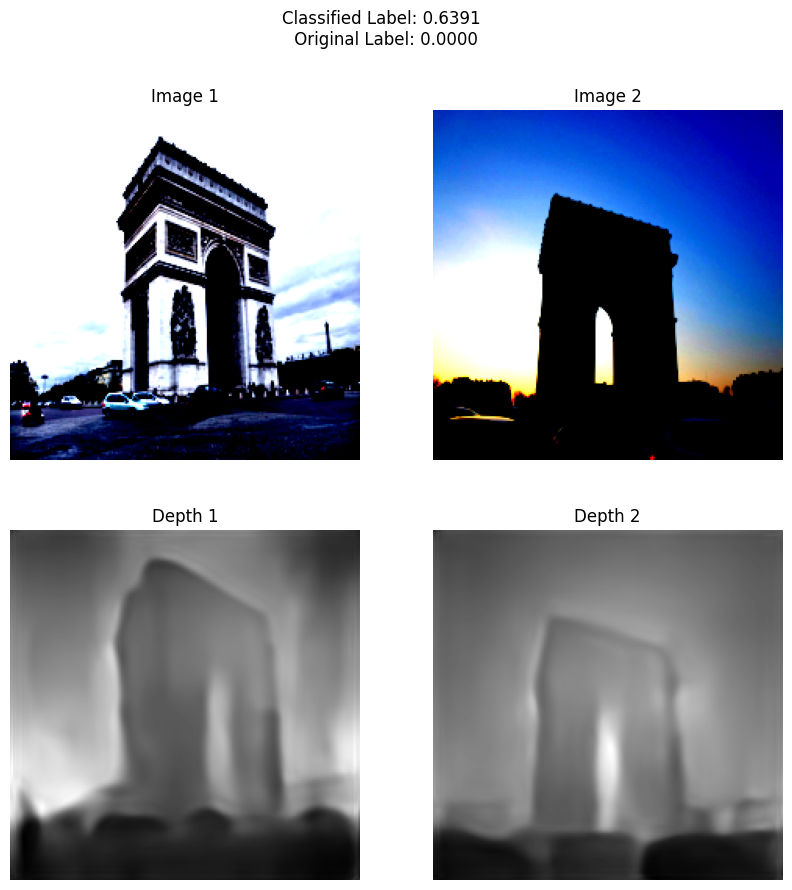

In [31]:
test_n_pairs()

# Kết luận

Có thể thấy việc sử dụng depther nhìn chung mang lại hiệu quả rõ rệt hơn, cho thấy tính khả thi và tiềm năng của hướng phát triển đã đề xuất. Backbone xác định feature tốt và có độ chuẩn xác cao về mặt vị trí.\
\
Tuy nhiên thông qua visualize kết quả, ta có thể thấy rằng dinov2 backbone coi các cấu trúc 3D (mục tiêu chính của bài toán) như là feature phụ (có thể thấy rõ ở độ mờ trong ảnh depther), trong khi các feature ngoại cảnh của bài toán như cây cối, phương tiện di chuyển, con người, ... lại được backbone coi là mục tiêu chính của ảnh nếu các feature này có xuất hiện trong ảnh.\
Điều này hoàn toàn hợp lý với bản chất của dinov2 vốn là model cho mục đích chung. Việc khắc phục, xử lý tình trạng tập trung vào các feature ngoại cảnh là hoàn toàn khả thi, đặc biệt là khi làm việc với tác vụ matching, SfM for 3D Reconstruction (future works).

# Các findings về NeRF và mối quan hệ với Doppelgangers matching

Các findings về NeRF, NerfStudio (sơ lược), và liên hệ với Doppelgangers được viết trong file "Research_quick_findings.docx"\
\
Phần nội dung trong docx vẫn chưa bổ sung nội dung về Structure from Motion (SfM). Sẽ được bổ sung trong tương lai trong quá trình phát triển project.